#  Bike vs Car recognition using classical-quantum Neural Network

In [4]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchsummary import summary
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision.io import read_image

from sklearn.model_selection import train_test_split

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os, random, json, cv2, math
from PIL import Image
from tqdm import tqdm

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

## Exploratory Data Analysis (EDA)

Car                    : 100%|███████████████████████████████████████████| 300/300 [00:01<00:00, 269.11file/s]


2 kind of images were found in the dataset
600 images were found in the dataset.
420 for training, 90 for validation
average image height=  274   average image width=  412  aspect ratio h/w=  0.6650485436893204


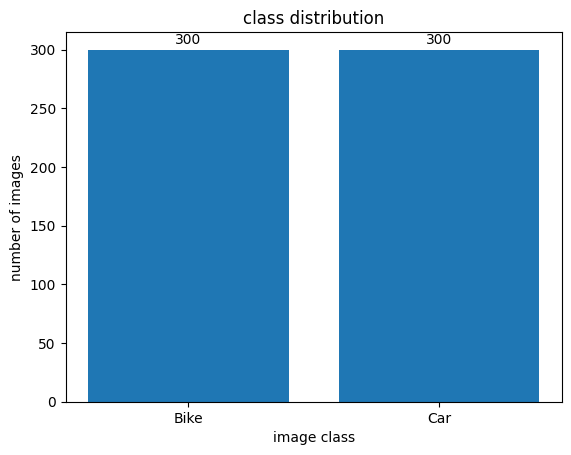

In [ ]:
root = 'Dataset'

def read_split_data(root, plot_image=False):
    filepaths = []
    labels = []
    bad_images = []

    random.seed(0)
    assert os.path.exists(root)

    classes = [cla for cla in os.listdir(root) if os.path.isdir(os.path.join(root, cla))]
    classes.sort()
    class_indices = {k: v for v, k in enumerate(classes)}

    json_str = json.dumps({v: k for k, v in class_indices.items()}, indent=4)

    with open('classes_indices.json', 'w') as json_file:
        json_file.write(json_str)

    every_class_num = []
    supported = ['.jpg', '.png', '.jpeg', '.PNG', '.JPG', '.JPEG']

    for klass in classes:
        classpath = os.path.join(root, klass)
        images = [os.path.join(root, klass, i) for i in os.listdir(classpath) if os.path.splitext(i)[-1] in supported]
        every_class_num.append(len(images))
        flist = sorted(os.listdir(classpath))
        desc = f'{klass:23s}'
        for f in tqdm(flist, ncols=110, desc=desc, unit='file', colour='blue'):
            fpath = os.path.join(classpath, f)
            fl = f.lower()
            index = fl.rfind('.')
            ext = fl[index:]
            if ext in supported:
                try:
                    img = cv2.imread(fpath)
                    filepaths.append(fpath)
                    labels.append(klass)
                except:
                    bad_images.append(fpath)
                    print('defective image file: ', fpath)
            else:
                bad_images.append(fpath)
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis=1)
    print(f'{len(df.labels.unique())} kind of images were found in the dataset')

    train_df, rest_df = train_test_split(df, train_size=.7, shuffle=True, random_state=123, stratify=df['labels'])
    valid_df, test_df = train_test_split(rest_df, train_size=.5, shuffle=True, random_state=123, stratify=rest_df['labels'])

    train_image_path = train_df['filepaths'].tolist()
    val_image_path = valid_df['filepaths'].tolist()
    test_image_path = test_df['filepaths'].tolist()

    train_image_label = [class_indices[i] for i in train_df['labels'].tolist()]
    val_image_label = [class_indices[i] for i in valid_df['labels'].tolist()]
    test_image_label = [class_indices[i] for i in test_df['labels'].tolist()]
    
    sample_df = train_df.sample(n=50, replace=False)
    ht, wt, count = 0, 0, 0
    for i in range(len(sample_df)):
        fpath = sample_df['filepaths'].iloc[i]
        try:
            img = cv2.imread(fpath)
            h = img.shape[0]
            w = img.shape[1]
            ht += h
            wt += w
            count += 1
        except:
            pass
    have = int(ht / count)
    wave = int(wt / count)
    aspect_ratio = have / wave
    print('{} images were found in the dataset.\n{} for training, {} for validation'.format(
        sum(every_class_num), len(train_image_path), len(val_image_path)
    ))
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)

    if plot_image:
        plt.bar(range(len(classes)), every_class_num, align='center')
        plt.xticks(range(len(classes)), classes)

        for i, v in enumerate(every_class_num):
            plt.text(x=i, y=v + 5, s=str(v), ha='center')

        plt.xlabel('image class')
        plt.ylabel('number of images')

        plt.title('class distribution')
        plt.show()

    return train_image_path, train_image_label, val_image_path, val_image_label, test_image_path, test_image_label, class_indices

train_image_path, train_image_label, val_image_path, val_image_label, test_image_path, test_image_label, class_indices = read_split_data(root, plot_image=True)

## Data loading

In [3]:
class MyDataset(Dataset):
    def __init__(self, image_path, image_labels, transform=None):
        self.image_path = image_path
        self.image_class = image_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, item):
        img = Image.open(self.image_path[item]).convert('RGB')
        label = self.image_class[item]

        if self.transform is not None:
            img = self.transform(img)
        return img, label

    # DataLoader
    @staticmethod
    def collate_fn(batch):
        images, labels = tuple(zip(*batch))
        images = torch.stack(images, dim=0)
        labels = torch.as_tensor(labels)
        return images, labels

In [4]:
batch_size = 1
in_size = 200

data_transform = {
    'train': transforms.Compose([transforms.Resize(in_size), transforms.CenterCrop(250), 
                                 transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'valid': transforms.Compose([transforms.Resize(in_size), transforms.CenterCrop(250), 
                                 transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'test': transforms.Compose([transforms.Resize(in_size), transforms.CenterCrop(250), 
                                 transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
}

train_dataset = MyDataset(train_image_path, train_image_label, transform=data_transform['train'])
trainloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=0, collate_fn=train_dataset.collate_fn)

valid_dataset = MyDataset(val_image_path, val_image_label, transform=data_transform['valid'])
validloader = DataLoader(valid_dataset, shuffle=False, batch_size=1, num_workers=0, collate_fn=valid_dataset.collate_fn)

test_dataset = MyDataset(test_image_path, train_image_label, transform=data_transform['test'])
testloader = DataLoader(test_dataset, shuffle=False, batch_size=1, num_workers=0, collate_fn=train_dataset.collate_fn)

In [5]:
inputs, targets = next(iter(trainloader))
print(inputs.shape)

torch.Size([1, 3, 250, 250])


## Quantum-Classical class

In [5]:
### QUANTUM CLASS ###

class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        expectations = []
        if type(result)==list:
            for i in result:
                counts = np.array(list(i.values()))
                states = np.array(list(i.keys())).astype(float)
            
                # Compute probabilities for each state
                probabilities = counts / self.shots
                # Get state expectation
                expectation = np.sum(states * probabilities)

                expectations.append(expectation)
        else:
            counts = np.array(list(result.values()))
            states = np.array(list(result.keys())).astype(float)
        
            # Compute probabilities for each state
            probabilities = counts / self.shots
            # Get state expectation
            expectation = np.sum(states * probabilities)

            expectations.append(expectation)

        return np.array(expectations)

In [6]:
### QUANTUM-CLASSICAL CLASS ###

class HybridFunction(torch.autograd.Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input.tolist())
        result = torch.tensor([expectation_z])
        
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run([shift_right[i]])
            expectation_left  = ctx.quantum_circuit.run([shift_left[i]])
            gradient = expectation_right - expectation_left
            gradients.append(gradient)
        
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None



class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, n_qubits, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(n_qubits, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        if input.shape!=torch.Size([1, 1]):
            input = torch.squeeze(input)
        else:
            input = input[0]
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

## The Network

In [7]:
### HYBRID NEURAL NETWORK ###

class qcNet(nn.Module):
    def __init__(self):
        super(qcNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=2, padding=1)
        self.conv2 = nn.Conv2d(6, 15, kernel_size=3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=1)
        self.drop1 = nn.Dropout2d(p=0.2)
        self.drop2 = nn.Dropout2d(p=0.5)
        self.fc1 = nn.Linear(55815, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        self.hybrid = Hybrid(self.fc3.out_features, qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.drop1(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.drop1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.drop2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.hybrid(x).T
        x = torch.cat((x, 1 - x), -1)
        return x

In [8]:
model = qcNet()

# hyper parameters
epochs=30
initial_lr = 0.00001
w_decay = 0.001

summary(model, (3,250,250))

/home/orazio/anaconda3/envs/quantum/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 124, 124]             456
         MaxPool2d-2          [-1, 6, 123, 123]               0
         Dropout2d-3          [-1, 6, 123, 123]               0
            Conv2d-4           [-1, 15, 62, 62]             825
         MaxPool2d-5           [-1, 15, 61, 61]               0
         Dropout2d-6           [-1, 15, 61, 61]               0
            Linear-7                  [-1, 120]       6,697,920
         Dropout2d-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
           Linear-10                    [-1, 1]              85
           Hybrid-11                    [-1, 2]               0
Total params: 6,709,450
Trainable params: 6,709,450
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.72
Forw

/tmp/ipykernel_398/3760997030.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525493953/work/torch/csrc/utils/tensor_new.cpp:230.)
  result = torch.tensor([expectation_z])


Epoch 1/30, train loss: -0.5063809506949924, val loss: -0.5269999999999998
Epoch 2/30, train loss: -0.5352380949028192, val loss: -0.5643333333333336
Epoch 3/30, train loss: -0.5836666657012843, val loss: -0.6068888888888888
Epoch 4/30, train loss: -0.598809524004658, val loss: -0.635
Epoch 5/30, train loss: -0.6383809524233497, val loss: -0.6305555555555554
Epoch 6/30, train loss: -0.6342142875705447, val loss: -0.6846666666666665
Epoch 7/30, train loss: -0.6534285711701072, val loss: -0.6922222222222223
Epoch 8/30, train loss: -0.6776666677202142, val loss: -0.7110000000000001
Epoch 9/30, train loss: -0.7157142864717614, val loss: -0.7017777777777778
Epoch 10/30, train loss: -0.713333335279354, val loss: -0.7227777777777777
Epoch 11/30, train loss: -0.726380951928773, val loss: -0.7303333333333332
Epoch 12/30, train loss: -0.7189523833981227, val loss: -0.7303333333333335
Epoch 13/30, train loss: -0.7348333346746152, val loss: -0.7277777777777777
Epoch 14/30, train loss: -0.752000000

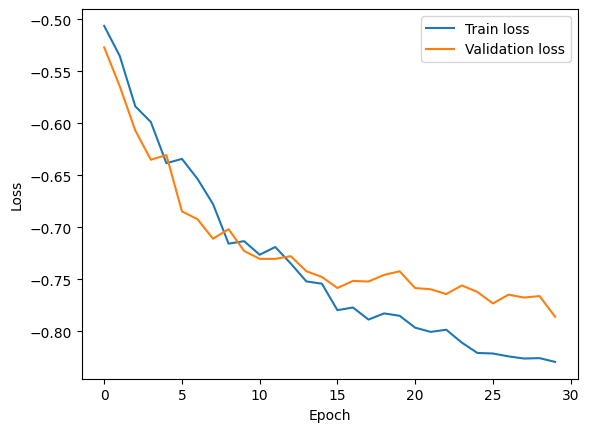

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, weight_decay=w_decay, amsgrad=True)
loss_fn = nn.NLLLoss()

# train the network and plot the learning curves
train_loss = []
valid_loss = []
for epoch in range(epochs):
    
    model.train()
    running_train_loss = 0.0
    for batch, (images, labels) in enumerate(trainloader):

        output = model(images).float()
        loss = loss_fn(output, labels)
        
        # foward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    train_loss.append(running_train_loss / len(trainloader))

    model.eval()
    running_val_loss = 0.0
    
    with torch.no_grad():
        for batch, (images, labels) in enumerate(validloader):
            output = model(images)
            loss = loss_fn(output, labels)
            running_val_loss += loss.item()
        valid_loss.append(running_val_loss/len(validloader))
        
    print(f"Epoch {epoch+1}/{epochs}, train loss: {train_loss[-1]}, val loss: {valid_loss[-1]}")

plt.plot(range(epochs), train_loss, label="Train loss")
plt.plot(range(epochs), valid_loss, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [24]:
model.eval()
with torch.no_grad():
    correct = 0
    total_loss = []
    for batch_idx, (data, target) in enumerate(testloader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_fn(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(testloader) * 100)
        )


Performance on test data:
	Loss: -0.7819
	Accuracy: 86.7%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

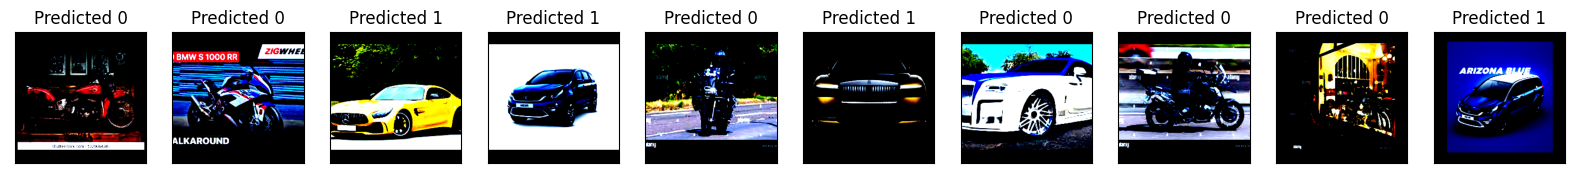

In [25]:
n_samples_show = 10
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(20, 10))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(testloader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True)
        
        data.squeeze_(0)
        axes[count].imshow(data.permute(1, 2, 0))
        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1